In [12]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
import seaborn as sns
# the first time to build font cache
from plotnine import *
from landscape import multiLandscape

# control the working directory
print(os.getcwd())

# data import and pandas manipulation
fp_savi = "../../input.savi.txt"
cutoff_refdepth_B = 20
cutoff_altdepth_B = 1
cutoff_freq = 5

# function 1
raw_data = pd.read_csv(fp_savi, delimiter="\t", index_col=False)
#print(raw_data.describe())

df_savi = raw_data.loc[lambda df:(df["refdepth_Blood"] >= cutoff_refdepth_B) &
                                 (df["altdepth_Blood"] <= cutoff_altdepth_B) &
                                 (df["Sgt1_max_frequency"] >= cutoff_freq), :]
df_savi = df_savi.fillna(0)

print(df_savi.columns)


/Users/jihongtang/Documents/GitHub/CELLO/CELLOP/PythonCode
Index(['chr', 'pos', 'ref', 'alt', 'Effect', 'Effect_Impact',
       'Functional_Class', 'Codon_Change', 'Amino_Acid_Change',
       'Amino_Acid_length', 'Gene_Name', 'Sgt1_max_frequency',
       'totdepth_Blood', 'totdepth_Primary', 'totdepth_Recurrent',
       'Blood_freq', 'Primary_freq', 'Recurrent_freq', 'refdepth_Blood',
       'altdepth_Blood', 'refdepth_Primary', 'altdepth_Primary',
       'refdepth_Recurrent', 'altdepth_Recurrent', 'CaseID', 'varPrefix',
       'varSurffix'],
      dtype='object')


In [13]:
# Cell for function mutStats preparation
# function 2
df_savi = df_savi
genelist_selected = ['LTBP4', 'PTPN11', 'NF1', 'RB1', 'PDGFRA',
                     'PIK3CG', 'PIK3R1', 'PIK3CA', 'PTEN', 'EGFR', 'IDH1', 'ATRX', 'TP53']
cutoff_freq = 5
remove_LOW = True

# remove the synonymous variant labelled by LOW in feature Effect_Impact
if(remove_LOW):
    df_savi = df_savi.loc[lambda df: df["Effect_Impact"] != 'LOW', :]

# pandas Series object ==> list data structure
case = df_savi["CaseID"].drop_duplicates().tolist()

# counting different mutations
mut_P = [0] * len(case)
mut_R = [0] * len(case)
mut_C = [0] * len(case)

# use lambda function to count mutations in different type
for i in range(len(case)):
    mut_C[i] = (lambda df: (df["CaseID"] == case[i])
                & (df["Primary_freq"] >= cutoff_freq)
                & (df["Recurrent_freq"] >= cutoff_freq)
                )(df_savi).sum()
    mut_P[i] = (lambda df: (df["CaseID"] == case[i])
                & (df["Primary_freq"] >= cutoff_freq)
                & (df["Recurrent_freq"] < cutoff_freq)
                )(df_savi).sum()
    mut_R[i] = (lambda df: (df["CaseID"] == case[i])
                & (df["Primary_freq"] < cutoff_freq)
                & (df["Recurrent_freq"] >= cutoff_freq)
                )(df_savi).sum()

df_mut_num = pd.DataFrame({'Patient': case,
                           'Primary': mut_P,
                           'Common': mut_C,
                           'Recurrent': mut_R})


In [14]:
# create 2D list in python using following format to make sure to create several
# separate lists in the second dimension
list_mut_gene = [['N'] * len(genelist_selected) for _ in range(len(case))]
df_savi_gene = df_savi[df_savi.Gene_Name.isin(genelist_selected)]

geneSel = genelist_selected
for i in range(len(case)):
    for j in range(len(geneSel)):
        temp_P = df_savi_gene.Primary_freq[(df_savi_gene.CaseID == case[i]) & (
            df_savi_gene.Gene_Name == geneSel[j])]
        temp_R = df_savi_gene.Recurrent_freq[(df_savi_gene.CaseID == case[i]) & (
            df_savi_gene.Gene_Name == geneSel[j])]
        if any(temp_P >= cutoff_freq) & any(temp_R >= cutoff_freq):
            list_mut_gene[i][j] = 'C'
        elif any(temp_P >= cutoff_freq):
            list_mut_gene[i][j] = 'P'
        elif any(temp_R >= cutoff_freq):
            list_mut_gene[i][j] = 'R'
        else:
            list_mut_gene[i][j] = 'N'

df_mut_gene = pd.DataFrame(np.array(list_mut_gene), columns=geneSel)
df_mut_gene.index = case


/var/folders/97/jxd2mhl11dj3l4hr3g97k_zm0000gn/T/ipykernel_64896/1940327272.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


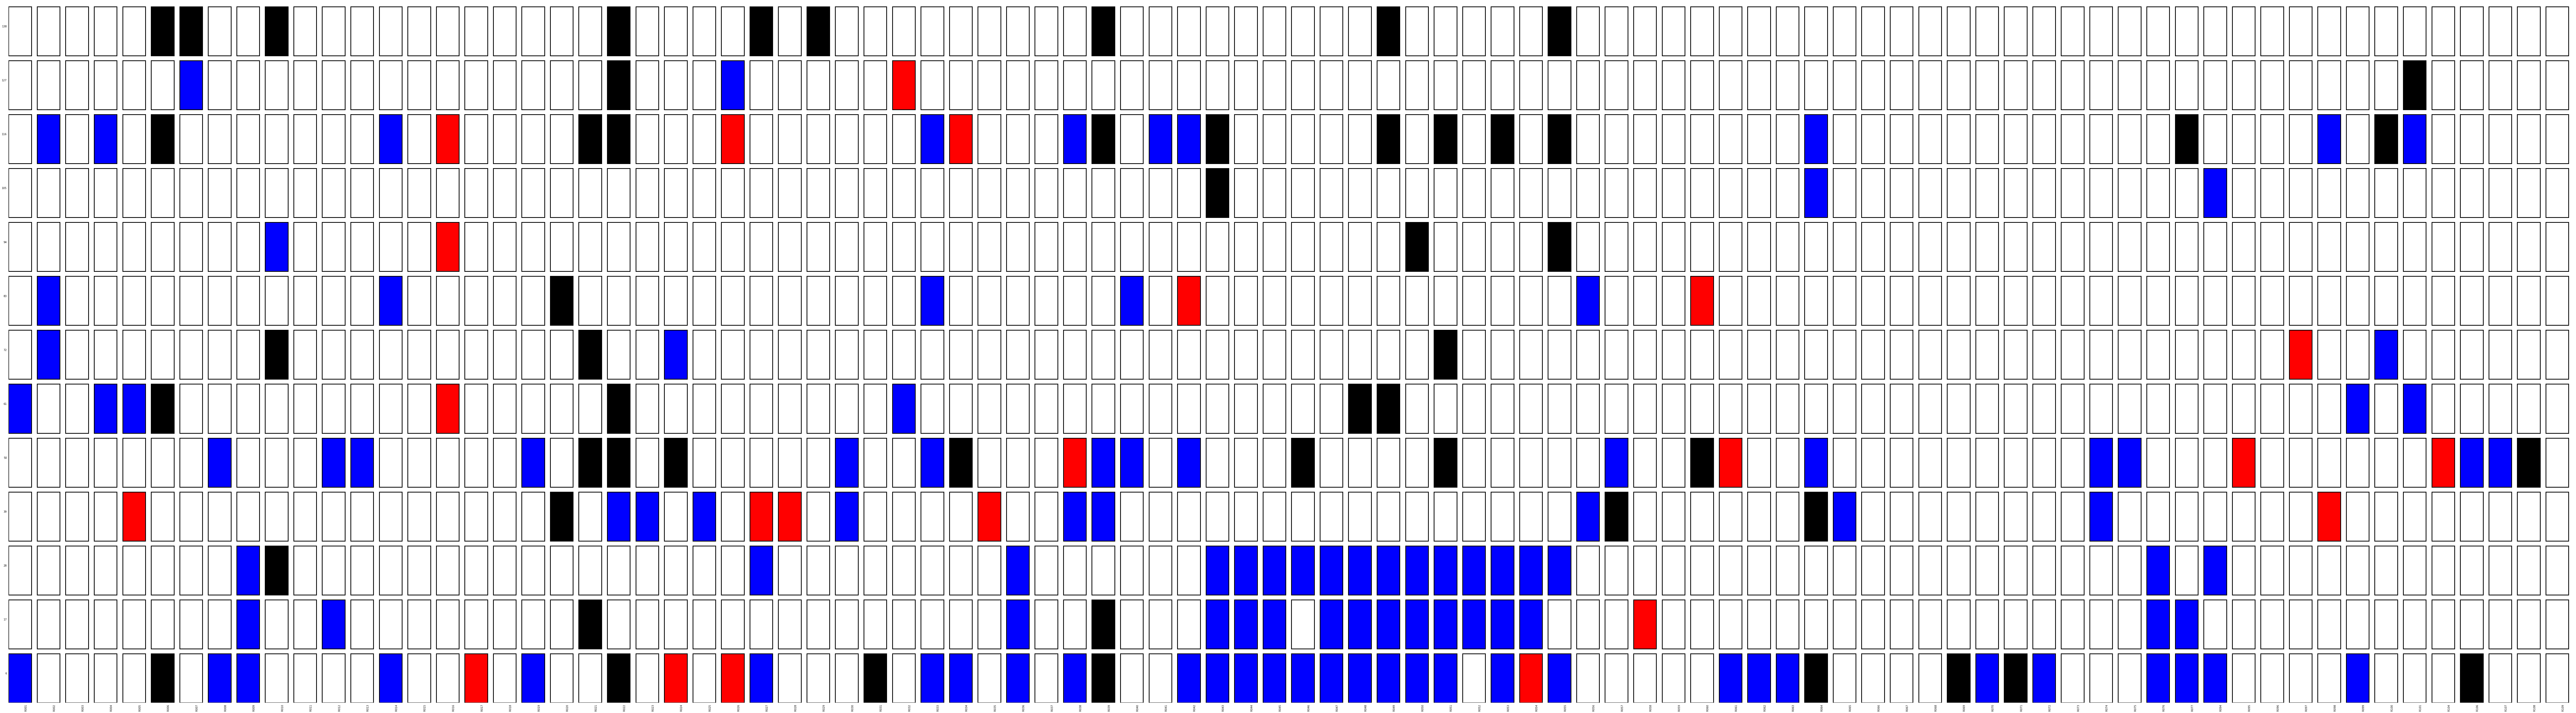

In [18]:
class colorDf(pd.DataFrame):
    def __init__(self, df, colorDict):
        super().__init__(df)
        self.colorDict = colorDict

cdf1 = colorDf(df_mut_gene.T, colorDict={'C':'blue', 'N':'white', 'P':'red', 'R':'black'})
multiLandscape([cdf1])
